# Task Description

- 올거나이즈 RAG-Evaluation-Dataset-Ko 데이터셋을 활용해서 RAG 시스템 구축하기
  - https://huggingface.co/datasets/allganize/RAG-Evaluation-Dataset-KO

- 사용자가 질문할 때, 5개의 도메인 중 하나를 선택해서 질문한다고 가정
  - finance, public, medical, law, commerce

- 사용자의 질문에 대한 답을 관련 문서에 기반해서 생성하기

## WorkFlow

- 도메인별 PDF 문서 로딩 및 전처리

- 문서 분할 (Chunking)
- KoE5 임베딩 및 Chroma 벡터스토어 생성
- Retriever로 유사 문서 검색 (Top-10)
- Re-ranker로 정확도 높은 문서 재정렬 (Top-6)
- Prompt 구성
- GPT-4o-mini로 정답 생성
- 결과 저장 및 평가


# Set Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 평가를 위한 패키지
!pip install mlflow
!pip install langchain
!pip install langchain-openai
!pip install langchain-anthropic
!pip install ragas

# vector store를 위한 패키지
!pip install langchain_chroma
#!pip install pypdf
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.4/303.4 kB 7.3 MB/s eta 0:00:00


# 데이터 분석 및 필요한 PDF 다운로드  
- 사용된 pdf만 다운로드 했습니다.
  - 총 63개 중 53개 사용

In [ ]:
import pandas as pd
df = pd.read_csv("hf://datasets/allganize/RAG-Evaluation-Dataset-KO/rag_evaluation_result.csv")
df.head(1)

# 필요한 column 파악: domain, question, target_answer, target_file_name

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,domain,question,target_answer,target_file_name,target_page_no,context_type,alli_gpt-4-turbo_answer,alli_gpt-4-turbo_ox,alli_gpt-4_answer,alli_gpt-4_ox,...,anything_llm_claude3-opus_answer,anything_llm_claude3-opus_ox,upstage_gpt-3.5-turbo_answer,upstage_gpt-3.5-turbo_ox,upstage_gpt-4-turbo_answer,upstage_gpt-4-turbo_ox,upstage_gpt-4_answer,upstage_gpt-4_ox,upstage_solar_answer,upstage_solar_ox
0,finance,"시중은행, 지방은행, 인터넷은행의 인가 요건 및 절차에 차이가 있는데 그 차이점은 ...","시중은행, 지방은행, 인터넷은행 모두 은행업을 영위하기 위해서는 '은행법' 제8조에...",[별첨] 지방은행의 시중은행 전환시 인가방식 및 절차.pdf,4,paragraph,"시중은행, 지방은행, 인터넷은행의 인가 요건 및 절차에서 차이점은 주로 최저자본금과...",O,"시중은행, 지방은행, 인터넷은행의 인가 요건 및 절차는 대부분 동일하지만, 일부 인...",O,...,"제공해주신 자료에는 시중은행, 지방은행, 인터넷은행의 인가 요건 및 절차의 차이점에...",X,"시중은행, 지방은행, 인터넷은행은 대부분 인가 요건 및 절차가 동일하지만, 최저자본...",X,"시중은행, 지방은행, 인터넷은행 모두 은행법 제8조에 따라 금융위원회의 인가를 받아...",O,"시중은행, 지방은행 및 인터넷은행 모두 은행법 제8조에 따라 금융위원회의 인가를 받...",O,"시중은행, 지방은행, 인터넷은행의 인가 요건 및 절차에 차이가 있습니다. 시중은행,...",O


In [ ]:
# 어떤 문서가 필요한지 확인 및 다운로드
## document.csv 중에서, 위의 data의 target_file_name에 있는 pdf만 다운로드
### pdf 다운로드 안 되는 것들만 직접 다운로드
target_file_list = df['target_file_name'].unique()
url = "https://huggingface.co/datasets/allganize/RAG-Evaluation-Dataset-KO/resolve/main/documents.csv"

pdf_file_information = pd.read_csv(url)

url_domain_list=[]
for target in target_file_list:
    if target in pdf_file_information['file_name'].tolist():
        url = pdf_file_information[pdf_file_information['file_name']==target]['url'].iloc[0]
        domain = pdf_file_information[pdf_file_information['file_name']==target]['domain'].iloc[0]
        file_name = pdf_file_information[pdf_file_information['file_name']==target]['file_name'].iloc[0]
    else: # pdf 이름 달라서 예외
        url = "https://www.moe.go.kr/sub/infoRenew.do?page=72760&m=031101&s=moe"
        domain  = "public"
        file_name = '(보도자료)2024년+교육부+주요정책+추진계획+발표_보도자료.pdf'
    url_domain_list.append((url,domain,file_name))
url_domain_list

[('https://www.fsc.go.kr/po010102?srchCtgry=2',
  'finance',
  '[별첨] 지방은행의 시중은행 전환시 인가방식 및 절차.pdf'),
 ('https://www.kofia.or.kr/brd/m_52/view.do?seq=252&srchFr=&srchTo=&srchWord=&srchTp=&multi_itm_seq=0&itm_seq_1=0&itm_seq_2=0&company_cd=&company_nm=&page=1',
  'finance',
  '★2019 제1회 증시콘서트 자료집_최종★.pdf'),
 ('https://vwserver.kif.re.kr/flexer/viewer.jsp?dir=km&mid=10&cno=150310&fk=2013016987IQ&ft=0&ftype=pdf',
  'finance',
  '130292099630937500_KIFVIP2013-10.pdf'),
 ('https://vwserver.kif.re.kr/flexer/viewer.jsp?dir=km&mid=15&cno=303581&fk=2023000455IM&ft=0&ftype=pdf',
  'finance',
  '133178946057443204_WP22-05.pdf'),
 ('https://www.bok.or.kr/portal/bbs/B0000156/view.do?nttId=10082951&menuNo=200067&pageIndex=1',
  'finance',
  '2024년 3월_2. 통화신용정책 운영.pdf'),
 ('https://www.bok.or.kr/portal/bbs/B0000156/view.do?nttId=10082951&menuNo=200067&pageIndex=1',
  'finance',
  '2024년 3월_3. 향후 통화신용정책 방향.pdf'),
 ('https://www.fsc.go.kr/po010102?srchCtgry=2',
  'finance',
  '240130(보도자료) 지방은행의 시중은행 전환

In [ ]:
import requests
import os


data = url_domain_list
base_dir = "/content/drive/MyDrive/rag_pdf_files"

for url, domain, file_name in data:
    if url.lower().endswith(".pdf"):
        # PDF인 경우 다운로드
        domain_dir = os.path.join(base_dir, domain)
        os.makedirs(domain_dir, exist_ok=True)
        save_path = os.path.join(domain_dir, file_name)

        try:
            response = requests.get(url)
            if response.status_code == 200:
                with open(save_path, "wb") as f:
                    f.write(response.content)
                print(f"✅ 다운로드 완료: {save_path}")
            else:
                print(f"❌ 다운로드 실패: {url} (상태 코드 {response.status_code})")
        except Exception as e:
            print(f"❌ 오류 발생: {url} ({e})")
    else:
        # PDF 아닌 경우 파일명만 출력
        print(f"📄 PDF 아님, 파일명 출력: {file_name}")

# html 이거나 다운로드 실패한건 직접 추가

📄 PDF 아님, 파일명 출력: [별첨] 지방은행의 시중은행 전환시 인가방식 및 절차.pdf
📄 PDF 아님, 파일명 출력: ★2019 제1회 증시콘서트 자료집_최종★.pdf
📄 PDF 아님, 파일명 출력: 130292099630937500_KIFVIP2013-10.pdf
📄 PDF 아님, 파일명 출력: 133178946057443204_WP22-05.pdf
📄 PDF 아님, 파일명 출력: 2024년 3월_2. 통화신용정책 운영.pdf
📄 PDF 아님, 파일명 출력: 2024년 3월_3. 향후 통화신용정책 방향.pdf
📄 PDF 아님, 파일명 출력: 240130(보도자료) 지방은행의 시중은행 전환시 인가방식 및 절차.pdf
📄 PDF 아님, 파일명 출력: 240320(보도자료) 금융권의 상생금융 추진현황.pdf
📄 PDF 아님, 파일명 출력: 240409(보도자료) 금융위 핀테크 투자 생태계 활성화 나선다.pdf
📄 PDF 아님, 파일명 출력: 한-호주 퇴직연금 포럼_책자(최종).pdf
📄 PDF 아님, 파일명 출력: (240411보도자료) 재정동향 4월호.pdf
📄 PDF 아님, 파일명 출력: 2023_2027 국가재정운용계획 주요내용.pdf
📄 PDF 아님, 파일명 출력: 2024년+국립대학+육성사업+기본계획.pdf
📄 PDF 아님, 파일명 출력: 제4차(24_28)+학교도서관+진흥+기본계획.pdf
📄 PDF 아님, 파일명 출력: 국가안전시스템 개편 종합대책 대국민 보고(12.31. 기준).pdf
📄 PDF 아님, 파일명 출력: 외교부-2024년 앙골라개황(저).pdf
📄 PDF 아님, 파일명 출력: 240418 도로터널 결로대책 가이드라인(최종).pdf
📄 PDF 아님, 파일명 출력: 전문교육기관ᆞ항공훈련기관 지정ᆞ인가 및 안전관리 현황__.pdf
📄 PDF 아님, 파일명 출력: (보도자료)2024년+교육부+주요정책+추진계획+발표_보도자료.pdf
📄 PDF 아님, 파일명 출력: 240319 알기쉬운 청년농신보 책자(최종본)★_배포용.pdf
📄 PDF 아님

KeyboardInterrupt: 

# RAG 시스템 구축

- 프레임워크: LangChain

## PDF로부터 Domain 별 vector DB & Retriever 만들기
- PDF 로더 : PyPDFLoader -> PyMuPDFLoader
  - 한국어에 강하고 처리 속도 빠름
  - 특수문자 인코딩에 강함
  - 파싱 및 page 별 분할: loader.load_and_split()
- 청킹: MarkdownTextSplitter, #RecursiveCharacterTextSplitter(그냥 길이 기준 분할)
  - 마크다운 문법 인식 및 문서 구조를 인식하여 자연스럽게 분할
- vector store: Chroma
- embedding model: KoE5
  - https://huggingface.co/nlpai-lab/KoE5

### Retriever
- search_type: 벡터 유사도 기반
- top_k: 10개
  - 몇개 찾을건지 k와 chunk 사이즈에 따른 실험을 통해 정해야됨
- 참고: search_type 설정에 bm25가 없어서, 하이브리드 서치 하려면 직접 bm25 구현해서 가중치 주거나 혹은, 다른 솔루션(Elastic search 등) 사용

### Reranker
- reranker : Dongjin-kr/ko-reranker
  - https://huggingface.co/Dongjin-kr/ko-reranker
- reranked_k : 5개




In [ ]:
import glob
from tqdm import tqdm
from langchain_community.document_loaders import PyMuPDFLoader#PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter,MarkdownTextSplitter
from langchain_chroma import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

# 도메인 별로 vectore store 만들기
domains = ['finance', 'public', 'medical', 'law', 'commerce']
retrievers = {}  # 도메인별 retriever 저장용

# 임베딩 모델 지정
from langchain_community.embeddings import HuggingFaceEmbeddings
embedding_model = HuggingFaceEmbeddings(model_name="nlpai-lab/KoE5")

# 텍스트 분할기 정의
#text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, add_start_index=True)
text_splitter = MarkdownTextSplitter(chunk_size=800, chunk_overlap=200, add_start_index=True)

# 도메인별로 벡터스토어 생성
for domain in domains:

    # PDF 경로 로딩
    pdf_paths = glob.glob(f"/content/drive/MyDrive/rag_pdf_files/{domain}/*.pdf")
    all_docs = []

    for path in tqdm(pdf_paths, desc=f"Loading {domain} PDFs"):
        #loader = PyPDFLoader(path)
        loader = PyMuPDFLoader(path)
        docs = loader.load_and_split() # PDF를 페이지별 Document 리스트로 분리
        all_docs.extend(docs)

    if not all_docs:
        print(f"⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️  {domain}⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️⚠️")
        continue

    # 텍스트 청크 분할
    all_splits = text_splitter.split_documents(all_docs)

    # vectorstore 생성:
    vectorstore = Chroma.from_documents( # all_splits 안의 작은 텍스트 청크들을 벡터 임베딩 처리해서 벡터 DB(벡터스토어)를 만드는 함수
        documents=all_splits,
        embedding=embedding_model,
        collection_name=f"rag_{domain}"  # 도메인별로 컬렉션 구분
    )
    retriever = vectorstore.as_retriever( # vectorstore를 실제 검색용 객체인 Retriever로 변환
        search_type="similarity",
        search_kwargs={"k": 10}
    )

    retrievers[domain] = retriever

<ipython-input-3-b94254ac6003>:14: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="nlpai-lab/KoE5")


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

Loading commerce PDFs: 100%|██████████| 9/9 [00:12<00:00,  1.43s/it]


In [ ]:
all_splits[-1]

Document(metadata={'producer': 'Hancom PDF 1.3.0.542', 'creator': 'Hwp 2018 10.0.0.10846', 'creationdate': '2022-01-06T11:02:07+09:00', 'source': '/content/drive/MyDrive/rag_pdf_files/commerce/PRP008.pdf', 'file_path': '/content/drive/MyDrive/rag_pdf_files/commerce/PRP008.pdf', 'total_pages': 6, 'format': 'PDF 1.6', 'title': '', 'author': 'andy', 'subject': '', 'keywords': '', 'moddate': '2023-11-15T10:34:30+09:00', 'trapped': '', 'modDate': "D:20231115103430+09'00'", 'creationDate': "D:20220106110207+09'00'", 'page': 5, 'start_index': 0}, page_content='06\nKREI 이슈+\n감     수\n 엄진영 연구위원\n061-820-2255\n jeom@krei.re.kr\n내용문의\n 홍연아 부연구위원061-820-2271\n yeonahong@krei.re.kr\n※ ｢KREI 이슈+｣는 농업·농촌의 주요 동향 및 정책 이슈를 분석하여 간략하게 정리한 것입니다.\n※ 이 자료는 우리 연구원 홈페이지(www.krei.re.kr)에서도 보실 수 있습니다.\n제8호\n신 농식품 마케팅 전략: 라이브커머스\n등   록\n제6-0007호(1979. 5. 25.)\n발   행\n2023. 11.\n발\n행\n인\n한두봉\n발\n행\n처\n한국농촌경제연구원\n우) 58321  전라남도 나주시 빛가람로 601\n대표전화 1833-5500\n인\n쇄\n처\n세일포커스(주)\nI S S N\n2983-3418\n※ 이 책에 실린 내용은 한국농촌경

In [ ]:
############# re-ranker 정의
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_path = "Dongjin-kr/ko-reranker"
tokenizer = AutoTokenizer.from_pretrained(model_path)
re_ranker = AutoModelForSequenceClassification.from_pretrained(model_path)
re_ranker.eval() # 학습용 레이어, gradient 계산 비활성화

def exp_normalize(x):
    b = x.max()
    y = np.exp(x - b)
    return y / y.sum()

def rerank_ko_reranker(query, docs, top_k=6):
    pairs = [[query, doc.page_content] for doc in docs]

    with torch.no_grad():
        inputs = tokenizer(pairs, padding=True, return_tensors='pt',
                           truncation=True, max_length=512 # 최대 길이 512넘으면 자름
                           )
        logits = re_ranker(**inputs).logits.view(-1).float() # 각 (q, 관련 텍스트) 에 대해서 점수 뽑는 거임.
        scores = exp_normalize(logits.numpy())

    ranked = sorted(zip(docs, scores), key=lambda x: x[1], reverse=True)
    return [doc for doc, _ in ranked[:top_k]]

tokenizer_config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/802 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

## 답변 생성하기
- LLM : Chatgpt-4o-mini
- 테스트 데이터셋: 도메인 당 10개
- 생성 prompt : rlm/ rag-prompt

In [ ]:
from langchain import hub
from langchain_openai import ChatOpenAI
import numpy as np
import os

# 최종 답변생성하는 llm  -> #########제출전 key 지우기########
os.environ["OPENAI_API_KEY"] = ""
llm = ChatOpenAI(model="gpt-4o-mini")

test_n = 10
prompt = hub.pull("rlm/rag-prompt")
'''
template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"
'''
df = pd.read_csv("hf://datasets/allganize/RAG-Evaluation-Dataset-KO/rag_evaluation_result.csv")

domains = ['finance', 'public', 'medical', 'law', 'commerce']

for domain in domains:

    # retriever
    retriever = retrievers[domain]

    # questions
    questions = df[df['domain']==domain]['question'][:test_n].tolist()

    # 답변생성
    results = []

    for q in tqdm(questions):
        retrieved_docs = retriever.invoke(q) # 탐색
        reranked_docs = rerank_ko_reranker(q, retrieved_docs, top_k=6)

        formatted_context = "\n\n".join(doc.page_content for doc in reranked_docs) # 탐색 결과 이어 붙이기
        #print(formatted_context)

        # prompt에 context, question 넣기
        prompt_result = prompt.invoke({"context": formatted_context, "question": q})
        #print(prompt_result)

        # llm에 들어가는 HumanMessage
        messages = prompt_result.to_messages()
        #print(messages)
        #break

        answer = llm.invoke(messages)

        results.append({
              "question": q,
              "answer": answer.content,
              "retrieved_context": [i.page_content for i in reranked_docs]
        })

    # 결과를 CSV로 저장
    result  = pd.DataFrame(results)
    result.to_csv("/content/drive/MyDrive/rag_pdf_files/{}_rag_answers_with_context.csv".format(domain), index=False)


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
100%|██████████| 10/10 [05:33<00:00, 33.31s/it]


In [ ]:
result_law_ = pd.read_csv("/content/drive/MyDrive/rag_pdf_files/law_rag_answers_with_context.csv")
result_law_

,question,answer,retrieved_context
0,"원고가 주장하는 망인의 사망과 공무상 재해와의 관련성을 설명하고, 이에 따른 피고의...","원고는 피고의 처분이 위법하다는 주장을 하며, 망인의 사망이 재직 중의 사유로 금고...",['경까지 일어난 범죄로서 모두 원고가 공직에서 퇴직한 이후에 성립한 범죄이다. 결...
1,당직근무 시 유의사항은 무엇인가요?,"당직근무 시 유의사항으로는 임무 수행 중 발생할 수 있는 과실에 주의하고, 직무와 ...",['➁ 재직 중의 사유(직무와 관련이 없는 과실로 인한 경우 및 소속상관의 정당한 ...
2,망인이 석식이 끝난 후에 하는 스케이트보드 타기는 공무수행 또는 그에 따르는 행위에...,망인이 석식이 끝난 후에 하는 스케이트보드 타기는 공무수행 또는 그에 따르는 행위로...,"['없지만, 장래 공무원의 직무와 관련하여 뇌물을 주고받겠다는 양 당사자의 의사표시..."
3,"A가 개발한 이 사건 성능조절기능이 탑재된 J 버전 업데이트는 언제 배포되었고, 이...",피고 A가 개발한 성능조절기능이 탑재된 J 버전 업데이트는 2017년 1월 23일에...,['- 4 -\n2) 피고 A의 I 업데이트 관련 소프트웨어 개발 및 제공\n가) ...
4,이 사건 C의 사용자가 피고 B를 상대로 제기한 손해배상 청구 사건에서는 어떠한 결...,이 사건 C의 사용자가 피고 B를 상대로 제기한 손해배상 청구 사건에서는 제1심에서...,['- 10 -\n1) 관련 형사사건\n가) 이 사건 C의 사용자들은 ‘피고들의 대...
5,본 문서에서 언급된 피고 A가 고객에게 고지하지 않았던 C의 성능저하 사실은 어떠한...,피고 A가 고객에게 고지하지 않았던 C의 성능 저하 사실은 소비자기본법 제19조 제...,['- 12 -\n한다) 제48조 제2항을 위반한 불법행위에 해당한다.\n3) 고지...
6,소비자기본법에서 규정하는 사업자의 책무는 어떠한 것들이 있나요?,"소비자기본법에서 규정하는 사업자의 책무는 다음과 같습니다: 소비자는 생명, 신체 또...","['에게 보다 유익한 사용경험을 제공하기 위한 것이었다고 주장하고 있고, 이 사건 ..."
7,피고 A에게 신의성실의 원칙상 고지의무 혹은 설명의무를 인정해야 하는 이유는 무엇인가?,피고 A에게 신의성실의 원칙상 고지의무를 인정해야 하는 이유는 소비자와 사업자 간에...,"['체제인 I의 꾸준한 업데이트가 필수적이므로, 위 소프트웨어 사용권 계약은 계속적..."
8,원고가 뇌물공여죄와 특정범죄가중처벌등에관한 법률위반(알선수재)죄로 처벌받게 된 과정...,원고는 2018년 1월 22일에 뇌물공여죄와 특정범죄가중처벌법 위반(알선수재죄)로 ...,['- 2 -\n2. 항소취지\n 주문과 같다.\n이 유\n1. 처분의...
9,"제한결정내역에 대한 정보 중, 퇴직수당과 퇴직연금의 총액은 얼마인가요?","퇴직수당과 퇴직연금의 총액은 67,380,090원입니다. 이는 2021년 3월 29...","['사건을 ‘관련 형사 사건’이라 한다]. \n 다. 이에 피고는, 공무원연금법 ..."


In [ ]:
sample_law_1 = result_law_.iloc[3]
print("#############qusetion")
print(sample_law_1['question'])
print(" ")
print("############검색결과")
print(sample_law_1['retrieved_context'])
print(" ")
print("###########생성된 답변")
print(sample_law_1['answer'])
print(" ")
print("###########target 답변")
df[df['domain']=='law']['target_answer'][:test_n].tolist()[3]

#############qusetion
A가 개발한 이 사건 성능조절기능이 탑재된 J 버전 업데이트는 언제 배포되었고, 이를 사용자에게 어떠한 이유로 설명하였나요?
 
############검색결과
['- 4 -\n2) 피고 A의 I 업데이트 관련 소프트웨어 개발 및 제공\n가) 피고 A은 이 사건 전원 꺼짐 현상에 대응하여 C의 중앙처리장치(CPU) \n및 그래픽처리장치(GPU)와 같은 일부 시스템 구성요소의 최고 성능을 제한하며 관리\n하는 기능(이하 ‘이 사건 성능조절기능’이라 한다)이 담긴 소프트웨어를 개발하였고, 이\n에 따라 2017. 1. 23. D 시리즈에 대하여 이 사건 성능조절기능이 탑재된 J 버전 업데\n이트(이하 ‘J 업데이트’라 한다)를 배포하였다. 그런데 피고 A은 J 소프트웨어 업데이트\n가 있음을 알리면서 ‘J은 C 또는 N의 오류 수정 및 보안 향상을 포함합니다.’는 등의 \n설명만 표시하였을 뿐 그외에 이 사건 성능조절기능에 대하여는 별다른 언급을 하지 \n아니하였다.\n나) 이후 피고 A은 J 업데이트에 대하여 기존의 설명에 덧붙여 ‘이 업데이\n트는 또한, 작업부하량이 최대치일 때 전원 관리 기능을 향상시켜 C에서 예기치않은 \n전원 꺼짐 현상을 방지합니다(영문생략)’라는 취지의 설명을 추가하였다.1)\n다) 피고 A은 2017. 12. 2. K 시리즈에 대하여도 이 사건 성능조절기능이 \n포함된 M 버전 업데이트(이하 ’M 업데이트‘라 하고, J 업데이트와 통틀어 ’이 사건 업\n데이트‘라 한다)를 배포하였는데, 피고 A은 M 업데이트에 대하여 ‘M에는 O Pay Cash \n기능이 추가되어 O Pay로 친구 및 가족 간에 송금하고 금액을 요청하거나 받을 수 있\n습니다. 이 업데이트는 오류 수정 및 개선사항도 포함합니다.’는 등의 설명만 표시하였', '피고 A로서는 피고 A을 신뢰하여 이 사건 C을 구매한 소비자인 원고들에게 이 사건 \n업데이트를 설치할 것인지 여부를 스스로 선택할 수 있도록 이에 대한 충분한 설명을 \

"피고 A가 개발한 이 사건 성능조절기능이 탑재된 J 버전 업데이트는 2017년 1월 23일에 배포되었습니다. 이를 사용자에게 알리면서, 'J은 C 또는 N의 오류 수정 및 보안 향상을 포함합니다.'라고 설명하였으나, 성능조절기능에 대해서는 별도로 언급하지 않았습니다."

# 평가

## 1.ragas score:
- https://docs.ragas.io/en/v0.1.21/concepts/metrics/index.html
- 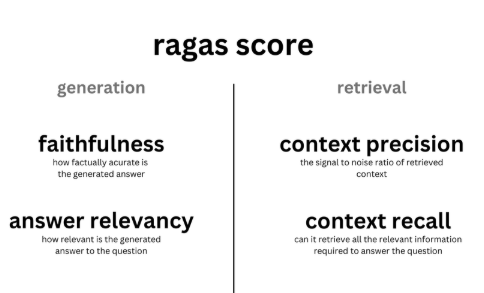

default llm: gpt-3.5-turbo

- answer_relevancy, # 생성 평가: 질문과 답변의 관계정도
- faithfulness, # 생성 평가: 답변이 얼마나 Context에 근거한 정확한 답변인지
- context_recall, # 검색 평가: 정답을 n개의 문장으로 쪼개고, 각 문장이 retrieved context에 있는지 확인
- context_precision # 검색 평가: 검색된 k개의 context 중에 정답(ground truth 만드는 데 도움이 되는지 확인) 비율

## 2.allganize 자동평가:
- https://huggingface.co/datasets/allganize/RAG-Evaluation-Dataset-KO 의 Auto Evaluate Colab 참조
- 총 4개의 LLM Eval을 사용하여 평가한 후, voting 하여 "O" 혹은 "X"를 결정했습니다.
- llm_evaluate() 함수
  - 밑의 4가지 평가 결과를 종합
  - O (정답) / X (오답)으로 통합 판단
  1. TonicAI : answer_similarity (threshold=4)
    - OpenAI 모델을 사용하여 생성된 답변과 기준 정답의 유사도를 0~5 점수로 출력
    - 평가 모델은 openai:/gpt-4o-mini 사용
  2. MLflow : answer_similarity/v1/score (threshold=4)
    - 0~5 스칼라 출력인듯
    - 평가 모델은 openai:/gpt-4o-mini 사용
  3. MLflow : answer_correctness/v1/score (threshold=4)
    - 0~5 스칼라 출력 인듯
    - 평가 모델은 openai:/gpt-4o-mini 사용
  4. Allganize Eval : answer_correctness/claude3-opus
    - 생성된 답변의 정확성을 기준 답변과 비교하여 검증
      - 맞으면 1, 틀리면 0 출력
    - 평가 모델은 "claude-3-opus-20240229" 사용



In [ ]:
def llm_evaluate(question: list, generated_answer: list, target_answer: list) -> list:
    """
    여러 평가 방법을 사용하여 LLM이 생성한 답변을 종합 평가합니다.

    Args:
        question (list): 질문 목록.
        generated_answer (list): 모델이 생성한 답변 목록.
        target_answer (list): 기준 답변 목록.

    Returns:
        list: 각 답변에 대한 최종 평가 결과 ('O'는 정답, 'X'는 오답).
    """
    tonic_answer_similarity = tonic_validate(question, generated_answer, target_answer, model="gpt-4o-mini")
    mlflow_answer_similarity, mlflow_answer_correctness = mlflow_eval(question, generated_answer, target_answer, model="openai:/gpt-4o-mini")
    allganize_answer_correctness = allganize_eval(question, generated_answer, target_answer, model="claude-3-opus-20240229")

    def get_evaluation_result(score: int) -> str:
      if score >= 4:
          return "O"
      else:
          return "X"
    def most_frequent_element(result: list) -> str:
        """
        리스트에서 가장 빈번하게 등장하는 요소를 반환하며, 특정 값에 우선순위를 둡니다.

        Args:
            result (list): 평가 결과 목록.

        Returns:
            str: 가장 빈번한 결과 ("O"는 정답, "X"는 오답).
        """
        count = Counter(result)
        priority = ["X", "O"]  # 'X'와 'O'에 대한 우선순위 정의

        most_common = count.most_common()
        for element in priority:
            if element in count and count[element] == most_common[0][1]:
                return element

    e2e_result = []
    for i in range(len(tonic_answer_similarity)):
        tonic_answer_similarity_ox = get_evaluation_result(tonic_answer_similarity[i])
        mlflow_answer_similarity_ox = get_evaluation_result(mlflow_answer_similarity[i])
        mlflow_answer_correctness_ox = get_evaluation_result(mlflow_answer_correctness[i])
        allganize_answer_correctness_ox = "O" if allganize_answer_correctness[i] == 1 else "X"

        # 가장 빈번한 평가 결과를 사용하여 종합 결과 결정
        e2e_result.append(
            most_frequent_element(
                [
                    tonic_answer_similarity_ox,
                    mlflow_answer_similarity_ox,
                    mlflow_answer_correctness_ox,
                    allganize_answer_correctness_ox,
                ]
            )
        )
    return e2e_result

In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_anthropic import ChatAnthropic
import mlflow
import logging
from collections import Counter

#########제출전 key 지우기########3
os.environ["ANTHROPIC_API_KEY"] = ""


# TONIC에서 생성된 답변과 기준 답변 간의 유사성을 비교하는 프롬프트 템플릿
TONIC_ANSWER_SIMILARITY_PROMPT = (
    "Considering the reference answer and the new answer to the following question, "
    "on a scale of 0 to 5, where 5 means the same and 0 means not at all similar, "
    "how similar in meaning is the new answer to the reference answer? Respond with just "
    "a number and no additional text.\nQUESTION: {question}\nREFERENCE ANSWER: {"
    "reference_answer}\nNEW ANSWER: {llm_answer}\n"
)
def tonic_validate(questions: list, generated_answers: list, target_answers: list, model: str) -> list:
    """
    생성된 답변과 기준 답변 간의 유사성을 특정 LLM을 사용하여 검증합니다.

    Args:
        questions (list): 질문 목록.
        generated_answers (list): 모델이 생성한 답변 목록.
        target_answers (list): 기준(정답) 답변 목록.
        model (str): 사용할 LLM 모델 이름.

    Returns:
        list: 각 답변 비교에 대한 유사성 점수 목록 (0 ~ 5).
    """
    llm = ChatOpenAI(model_name=model)

    prompt = PromptTemplate(
        input_variables=["question", "reference_answer", "llm_answer"], template=TONIC_ANSWER_SIMILARITY_PROMPT
    )
    chain = LLMChain(llm=llm, prompt=prompt)

    eval_check = []
    for question, target_answer, generated_answer in zip(tqdm(questions), target_answers, generated_answers):
        try:
            # LLM 체인을 실행하여 유사성 점수를 얻음
            llm_result = chain.run(
                {"question": question, "reference_answer": target_answer, "llm_answer": generated_answer}
            )
            eval_check.append(int(llm_result))
        except Exception as e:
            logger.warning(f"llm_eval exception: {e}")
            eval_check.append(-1)
    return eval_check

# ALLGANIZE에서 생성된 답변이 기준 답변과 일치하는지 확인하는 프롬프트 템플릿
ALLGANIZE_ANSWER_CORRECTNESS_PROMPT = """
question = \"\"\"
{question}
\"\"\"

target_answer = \"\"\"
{reference_answer}
\"\"\"

generated_answer = \"\"\"
{llm_answer}
\"\"\"

Check if target_answer and generated_answer match by referring to question.
If target_answer and generated_answer match 1, answer 0 if they do not match.
Only 1 or 0 must be created.
"""
def allganize_eval(
    questions: list, generated_answers: list, target_answers: list, model: str
) -> list:
    """
    생성된 답변의 정확성을 기준 답변과 비교하여 검증합니다.

    Args:
        questions (list): 질문 목록.
        generated_answers (list): 모델이 생성한 답변 목록.
        target_answers (list): 기준(정답) 답변 목록.
        model (str): 사용할 LLM 모델 이름.

    Returns:
        list: 정확성 점수 목록 (정확하면 1, 틀리면 0).
    """
    llm = ChatAnthropic(model=model)

    prompt = PromptTemplate(
        input_variables=["question", "reference_answer", "llm_answer", "contexts"],
        template=ALLGANIZE_ANSWER_CORRECTNESS_PROMPT,
    )
    chain = LLMChain(llm=llm, prompt=prompt)

    eval_check = []
    for question, target_answer, generated_answer in zip(tqdm(questions), target_answers, generated_answers):
        try:
            # LLM 체인을 실행하여 정확성 점수를 얻음
            llm_result = chain.run(
                {
                    "question": question,
                    "reference_answer": target_answer,
                    "llm_answer": generated_answer,
                }
            )
            eval_check.append(int(llm_result))
        except Exception as e:
            logger.warning(f"llm_eval exception: {e}")
            eval_check.append(-1)

    return eval_check
def mlflow_eval(question_list: list, answer_list: list, ground_truth_list: list, model: str):
    """
    MLflow 메트릭을 사용하여 답변의 유사성과 정확성을 평가합니다.

    Args:
        question_list (list): 질문 목록.
        answer_list (list): 생성된 답변 목록.
        ground_truth_list (list): 기준 답변 목록(정답).
        model (str): MLflow 평가에 사용할 모델 이름.

    Returns:
        tuple: MLflow 평가에서 나온 유사성 및 정확성 점수.
    """
    eval_data = pd.DataFrame({"inputs": question_list, "predictions": answer_list, "ground_truth": ground_truth_list})

    with mlflow.start_run():
        # 사용자 정의 메트릭을 사용하여 MLflow 평가 실행
        results = mlflow.evaluate(
            data=eval_data,
            targets="ground_truth",
            predictions="predictions",
            extra_metrics=[
                mlflow.metrics.genai.answer_similarity(model=model),
                mlflow.metrics.genai.answer_correctness(model=model),
            ],
            evaluators="default",
        )

        eval_table = results.tables["eval_results_table"]
        mlflow_answer_similarity = eval_table["answer_similarity/v1/score"].tolist()
        mlflow_answer_correctness = eval_table["answer_correctness/v1/score"].tolist()

    return mlflow_answer_similarity, mlflow_answer_correctness

In [ ]:
import ast
from ragas import evaluate
from ragas.metrics import (
    answer_relevancy, # 생성 평가: 질문과 답변의 관계정도
    faithfulness, # 생성 평가: 답변이 얼마나 Context에 근거한 정확한 답변인지
    context_recall, # 검색 평가: 정답을 n개의 문장으로 쪼개고, 각 문장이 retrieved context에 있는지 확인
    context_precision # 검색 평가: 검색된 k개의 context 중에 정답(ground truth 만드는 데 도움이 되는지 확인) 비율
)
from datasets import Dataset

domains = ['finance', 'public', 'medical', 'law', 'commerce']
domain_score = []
for domain in domains:

    result = pd.read_csv(f"/content/drive/MyDrive/rag_pdf_files/{domain}_rag_answers_with_context.csv")
    result["retrieved_context"] = result["retrieved_context"].apply(ast.literal_eval) # retrieved_contexts 컬럼을 문자열에서 리스트로 변환

    question, generated_answer, target_answer,contexts = result['question'].tolist(),result['answer'].tolist(),df[df['domain']==domain]['target_answer'][:test_n].tolist(),result['retrieved_context'].tolist()


    data_samples = {
        'question': question,
        'ground_truth': target_answer,
        'answer': generated_answer,
        'contexts':contexts

    }
    dataset = Dataset.from_dict(data_samples)

    ragas_score = evaluate(dataset, metrics=[answer_relevancy,
                                            faithfulness,
                                            context_recall,
                                            context_precision
                                            ])
    ragas_score = ragas_score.to_pandas()
    #ragas_answer_correctness = ["O" if ele > 0.6 else "X" for ele in ragas_score["answer_correctness"].tolist()]
    #ragas_answer_correctness = ragas_score["answer_correctness"].tolist()
    #ragas_answer_similarity = ragas_score["answer_similarity"].tolist()
    #ragas_score.head(1)


    result = llm_evaluate(question, generated_answer, target_answer)
    ragas_score["맞았나요"] = result
    ragas_score.columns = ["q","검색결과","답변","정답","g_relevancy","g_faithfulness","r_recall","r_precision","맞았나요"]
    #print(ragas_score)
    #print(domain,"Score: ",len(ragas_score[ragas_score[ragas_score.columns[-1]]=='O']) /len(ragas_score))
    domain_score.append(len(ragas_score[ragas_score[ragas_score.columns[-1]]=='O']) /len(ragas_score))

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

<ipython-input-18-14f82ad32ad3>:38: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=llm, prompt=prompt)
  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-18-14f82ad32ad3>:44: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  llm_result = chain.run(
100%|██████████| 10/10 [00:34<00:00,  3.50s/it]
2025/05/19 13:54:29 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.52it/s]
2025/05/19 13:55:53 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:04<00:00,  2.25it/s]
2025/05/19 13:57:10 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:34<00:00,  3.49s/it]
2025/05/19 13:58:28 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:03<00:00,  2.85it/s]
2025/05/19 13:59:18 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


In [ ]:
ragas_score

,q,검색결과,답변,정답,g_relevancy,g_faithfulness,r_recall,r_precision,맞았나요
0,코로나 19와 러시아-우크라이나 전쟁의 영향으로 전 세계적인 경제 불황이 닥친 상황...,[디지털경제연구원\n이슈페이퍼 23-2호\n이커머스(E-commerce)의 진화와 ...,"코로나19와 러시아-우크라이나 전쟁으로 인해 경제 불황이 이어지는 가운데, 체리슈머...","체리슈머라는 새로운 소비 트렌드가 등장했으며, 이는 이커머스를 기반으로 한 것이다....",0.876615,1.000000,1.0,0.887500,O
1,2020년과 2022년에 각각 어떤 변화가 있어 소비자 체감 물가 및 소비자 동향 ...,"[고, 연쇄지수상승률**(0.45%)과 비교해도 0.18%p 높았음(한국금융연구원,...","2020년에는 코로나19로 인해 소비자 체감 물가와 소비자동향지수가 위축되었으나, ...","2020년에는 코로나19의 확산으로 소비자동향지수가 100 이하로 하락하였고, 체감...",0.876528,1.000000,1.0,1.000000,O
2,"한국의 이커머스 시장은 지난 20년간 어떤 성장세를 보이고 있으며, 이를 통해 소비...","[- 체리슈머는 생존을 위해 사는 상품은 극도로 가성비를 따지지만, ‘사고 싶다’는...","한국의 이커머스 시장은 지난 20년간 연 평균 20%의 빠른 성장을 이뤘으며, 20...",한국의 이커머스 시장은 지난 20년간 연 평균 20%의 빠른 성장을 이루어냈습니다....,0.897746,1.000000,1.0,1.000000,O
3,"베블런 효과가 작용하여 럭셔리 시장에서 수요가 증가하는 심리적 요인은 무엇이며, 그...",[시작하며\nn 코로나19의 확산과 러시아-우크라이나 전쟁으로 인해 세계 경제가 위...,베블런 효과는 소비자들이 가격이 높은 럭셔리 제품을 선호함으로써 그러한 제품에 대한...,"럭셔리 제품의 소비에는 타인에게 보이기 위한 과시 욕구, 스스로의 만족감, 자기애,...",0.826682,0.250000,1.0,0.722222,O
4,"국내 럭셔리 시장 규모가 2020년 대비 2021년에 어느 정도로 성장했으며, 이러...",[78조\n112조\n135조\n161조\n186조\n22%\n18%\n19%\n1...,"국내 럭셔리 시장은 2020년 대비 2021년에 성장을 보였으며, 이커머스 시장이 ...","국내 럭셔리 시장은 2020년 44억 달러에서 2021년 58억 달러로 성장했으며,...",0.866787,0.833333,0.0,0.000000,X
5,"신명품 브랜드의 경제적 접근성과 브랜드 역사를 설명하고, 1980년대 이후 설립된 ...",[인 유통 채널 확장에 주력하고 있다. \n- \n네이버는 2020년 브랜드스토어...,신명품 브랜드는 경제적 접근성을 높이기 위해 다양한 유통 채널과 구독 경제 모델을 ...,"신명품 브랜드는 상대적으로 높은 경제적 접근성을 가지고 있어, 클래식 럭셔리 제품에...",0.806802,0.285714,0.0,0.000000,X
6,럭셔리 브랜드 기업들이 외식업계로 확장하는 이유와 그들이 제공하는 가치는 무엇인가요?,[아직까지 국내에서는 중고 플랫폼에 대한 관심이 크지 않다. 최근 롯데쇼핑이 FI와...,"럭셔리 브랜드 기업들이 외식업계로 확장하는 이유는 이커머스 효율성을 높이고, 배달인...",럭셔리 브랜드 기업들이 외식업계로 확장하는 이유는 소비자의 오감을 충족시키는 브랜드...,0.839022,0.000000,0.0,0.333333,X
7,2021년에 글로벌 사모펀드와 벤처 캐피털이 럭셔리 관련 기업에 투자한 액수와 이전...,[확장으로덩치\n키우기에나선\n전문쇼핑몰주요\n전문몰의거래액\n규모를통해\n버티컬커...,해당 정보는 제공된 컨텍스트에서 확인할 수 없습니다. 2021년의 글로벌 사모펀드와...,"2021년에는 글로벌 사모펀드와 벤처 캐피털이 럭셔리 관련 기업에 총 39억 6,0...",0.000000,1.000000,0.0,0.000000,X
8,국내 리세일 시장에서 개인 간 거래인 C2C 형태 거래의 어려움과 이를 해결하기 위...,[간 소비의 감소로 이어질 수 있기 때문에 소매유통채널 입장에서 긍정적 요인은 아니...,국내 C2C 중고거래에서 개인 간 거래의 어려움은 낮은 관심과 거래의 비효율성으로 ...,"국내 리세일 시장에서 C2C 형태의 거래시 탐색, 정품 확인, 결제 수단 등 여러 ...",0.867032,0.800000,1.0,0.250000,X
9,"애플과 구글이 적용한 개인정보보호 강화 정책으로 인하여, 향후 마케팅 전략에서 어떤...","[변화하는 시대, 변화하는 구매자\nMerit는 2025년까지 디지털 사용이 익숙한...",전문가들은 애플과 구글의 개인정보보호 강화 정책으로 인해 마케팅 전략에서 고객의 기...,"많은 데이터를 보유한 빅 매체사의 영향력이 더 커질 것이라고 예상되고, 서드파티 쿠...",0.886728,0.800000,1.0,0.833333,X


In [ ]:
pd.DataFrame({
    "domain": domains,
    "score": domain_score
})

,domain,score
0,finance,0.5
1,public,0.5
2,medical,0.4
3,law,0.7
4,commerce,0.4


# 개선할 수 있는 부분
## pre-filtering(검색 풀 미리 줄이기)
- 실험 결과 효과 있음
  - BERT 같은 Classifier
    - 데이터 증강 필요  
  - 혹은 LLM 활용가능
    - 문서에 대한 메타 데이터 및 설명 or 요약

## 파싱 및 청킹
- PDF 파서
  - ERROR:pypdf._cmap:Advanced encoding /KSCpc-EUC-H not implemented yet 해결 위해 다른 파서 사용
    - PyMuPDFLoader로 대체 했음

- 텍스트 분할기 실험
  - Content-Aware Splitting이 검색 성능 더 좋아서 대체함.
- **Contextual chunking**
 - **문서 hierarchy 기반으로 contextual를 추가한 chunk 구성**
- chunk 사이즈 및 top k 실험
  - 1. LLM 선정
  - 2. chunk 사이즈와 LLM의 Context Length 에 따라 k를 정하기
  - 3. retriever의 top-k recall 점수 측정


## retriever

- 임베딩 모델 실험
- reranker 모델 실험
- 임베딩, reranker 학습

#### 검색방법
- bm25 추가 및 하이브리드 서치 방법
  - chroma 에서 지원 안 하니까, FAISS +BM25Retriever

- 검색 방법 개선:
  - HyDE
    - https://aclanthology.org/2023.acl-long.99/
    - 1. **사용자의 질문 입력**: 사용자가 특정 질문을 입력한다.
      2. **가상 문서 생성**: 질문을 기반으로 LLM을 사용하여 관련성이 높은 가상의 문서를 생성한다.
      3. **임베딩 생성**: 생성된 가상 문서를 임베딩 모델로 벡터화한다.
      4. **유사도 비교 및 검색**: 생성된 벡터와 데이터베이스 문서의 벡터 간 유사도를 계산하여 가장 관련성이 높은 문서를 반환한다

  - HyQE
    - https://arxiv.org/abs/2410.15262

## generation
- 모델 선정
- prompt engineering

## 비용 측면
- prompt caching : 반복적으로 사용되는 프롬프트를 서버에 저장하여, 이후 동일한 프롬프트가 다시 들어왔을 때 이를 빠르게 처리하는 기능
  - https://www.anthropic.com/news/contextual-retrieval


